# Sentiment Analysis using Keras

**Natural Language Processing**:Natural language processing (NLP) refers to the branch of computer science—and more specifically, the branch of artificial intelligence or AI—concerned with giving computers the ability to understand text and spoken words in much the same way human beings can.

**Sentiment Analysis**:Sentiment analysis, also referred to as opinion mining, is an approach to natural language processing (NLP) that identifies the emotional tone behind a body of text. This is a popular way for organizations to determine and categorize opinions about a product, service, or idea. It involves the use of data mining, machine learning (ML) and artificial intelligence (AI) to mine text for sentiment and subjective information.

## Table of Contents

1. [Importing Dependencies](#p1)
2. [Importing Dataset](#p2)
3. [Dataset Preprocessing](#p3)
4. [Text Preprocessing](#p4)
5. [WordCloud](#p5)
6. [Train Test Split](#p6)
7. [Tokenization](#p7)
8. [Label Encoding](#p8)
9. [Word Embedding](#p9)
10. [Creating and Training Model](#p10)
11. [Plotting Graphs](#p11)
12. [Predictions](#p12)
13. [Classification Report and Confusion Matrix](#p13)

## <a name="p1">Importing Dependencies</a>

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

import re
import itertools

from wordcloud import WordCloud

## <a name="p2">Importing Dataset</a>

In [5]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding="ISO-8859-1",names=['sentiment', 'id', 'date', 'query', 'user_id', 'text'])

In [6]:
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## <a name="p3">Dataset Preprocessing</a>

In [8]:
#dropping unnecessary columns
df.drop(['id','date','query','user_id'],inplace=True,axis=1)

In [10]:
df['sentiment'].unique()

array([0, 4])

In [11]:
#decoding labels
lab_to_sentiment = {0:'Negative',4:'Positive'}
def label_decoder(label):
    return lab_to_sentiment[label]
df['sentiment'] = df['sentiment'].apply(lambda x : label_decoder(x))

In [13]:
df['sentiment'].unique()

array(['Negative', 'Positive'], dtype=object)

<AxesSubplot:xlabel='sentiment', ylabel='count'>

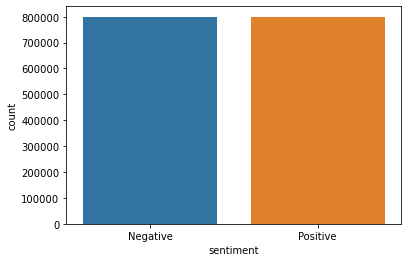

In [19]:
#dataset is balanced
import seaborn as sns
sns.countplot(x=df['sentiment'],data=df)

## <a name="p4">Text Preprocessing</a>

In [21]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [25]:
#removing stopwords and regular expressions
def preprocess(text):
    text = re.sub(text_cleaning_re,' ',str(text).lower().strip())
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(stemmer.stem(token))
    return ' '.join(tokens)

In [26]:
df['text'] = df['text'].apply(lambda x: preprocess(x))

In [27]:
df['text'][0]

'awww bummer shoulda got david carr third day'

## <a name="p5">WordCloud</a>

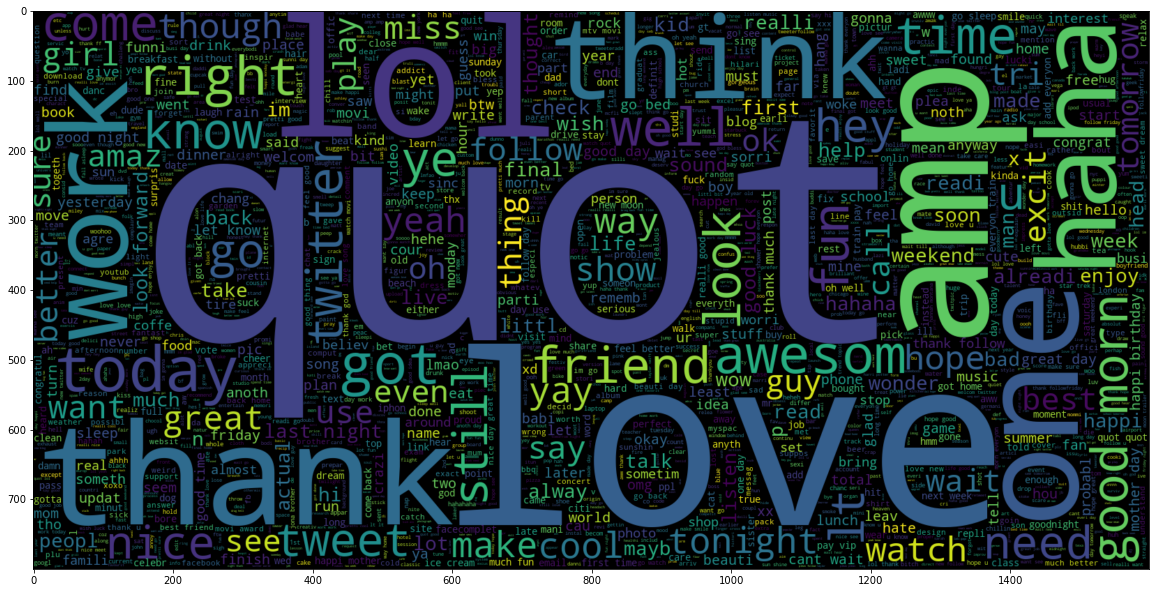

In [129]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

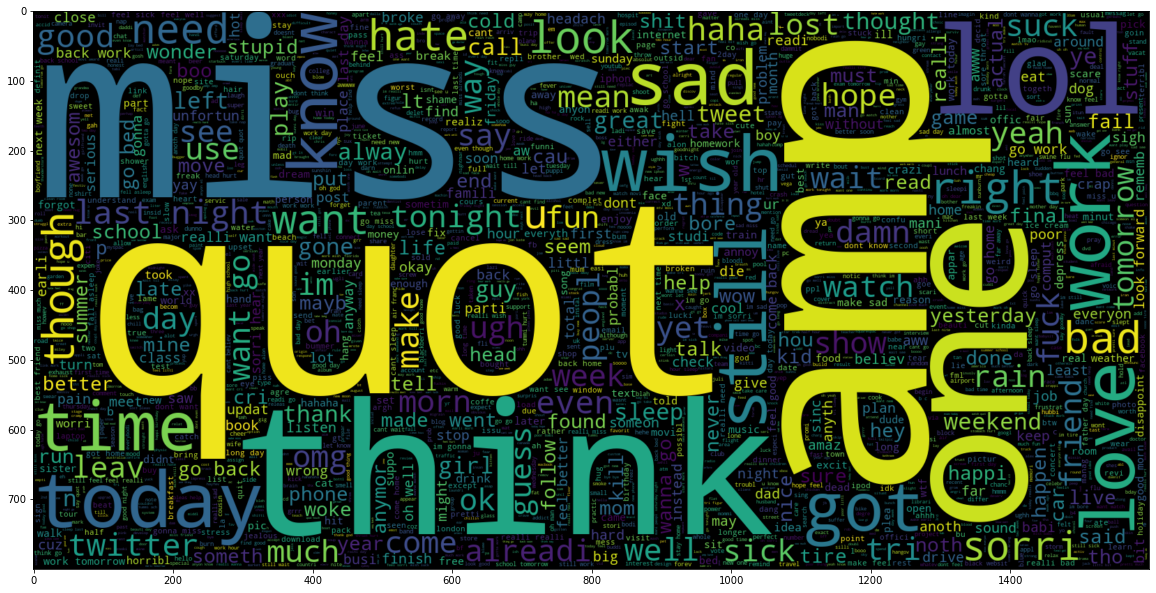

In [130]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

## <a name="p6">Train Test Split</a>

In [33]:
train_data,test_data = train_test_split(df,test_size=0.05,random_state=101)

In [34]:
train_data.shape

(1520000, 2)

In [35]:
test_data.shape

(80000, 2)

## <a name="p7">Tokenization</a>

In [37]:
tokenizer = Tokenizer()

In [38]:
tokenizer.fit_on_texts(train_data['text'])

In [41]:
word_index = tokenizer.word_index
vocab_size = len(word_index)+1

In [42]:
vocab_size

278603

In [48]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data['text']),maxlen=30)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data['text']),maxlen=30)

In [49]:
x_train.shape

(1520000, 30)

In [50]:
x_test.shape

(80000, 30)

## <a name="p8">Label Encoding</a>

In [52]:
encoder = LabelEncoder()
encoder.fit(train_data['sentiment'].to_list())

y_train = encoder.transform(train_data['sentiment'].to_list())
y_test = encoder.transform(test_data['sentiment'].to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

## <a name="p9">Word Embedding</a>

In [54]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-08-30 14:18:50--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-08-30 14:18:54--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-08-30 14:18:56--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [59]:
embedding_index = {}
f=open('glove.6B.300d.txt')
for line in f:
    values=line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:])
    embedding_index[word] = coefs
f.close()
print(f'{len(embedding_index)} Word Vectors Found')


400000 Word Vectors Found


In [67]:
word_index

{'go': 1,
 'get': 2,
 'day': 3,
 'good': 4,
 'work': 5,
 'like': 6,
 'love': 7,
 'quot': 8,
 'today': 9,
 'time': 10,
 'got': 11,
 'lol': 12,
 'thank': 13,
 'back': 14,
 'one': 15,
 'want': 16,
 'miss': 17,
 'u': 18,
 'know': 19,
 'see': 20,
 'think': 21,
 'feel': 22,
 'im': 23,
 'realli': 24,
 'amp': 25,
 'night': 26,
 'hope': 27,
 'watch': 28,
 'still': 29,
 'need': 30,
 'make': 31,
 'well': 32,
 '2': 33,
 'new': 34,
 'home': 35,
 'oh': 36,
 'look': 37,
 'come': 38,
 'much': 39,
 'last': 40,
 'twitter': 41,
 'morn': 42,
 'tomorrow': 43,
 'wish': 44,
 'great': 45,
 '3': 46,
 'sad': 47,
 'wait': 48,
 'sleep': 49,
 'haha': 50,
 'bad': 51,
 'fun': 52,
 'week': 53,
 'tri': 54,
 'right': 55,
 'follow': 56,
 'happi': 57,
 'would': 58,
 'friend': 59,
 'thing': 60,
 'sorri': 61,
 'tonight': 62,
 'say': 63,
 'way': 64,
 'take': 65,
 'nice': 66,
 'though': 67,
 'gonna': 68,
 'better': 69,
 'hate': 70,
 'even': 71,
 'yeah': 72,
 'bed': 73,
 'tweet': 74,
 'could': 75,
 'start': 76,
 'school': 77,

In [69]:
len(embedding_index['go'])

300

In [62]:
EMBEDDING_DIM=300
embedding_matrix = np.zeros((vocab_size,EMBEDDING_DIM))

for word,i in word_index.items():
    embedding_vector= embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector

## <a name="p10">Creating and Training Model</a>

In [84]:
LR = 1e-3

In [95]:
model = Sequential()
model.add(Embedding(vocab_size,EMBEDDING_DIM,weights=[embedding_matrix],input_length=30,trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])

In [97]:
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,min_lr = 0.01,monitor = 'val_loss',verbose = 1)

In [98]:
early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=1)

In [99]:
model.fit(x_train, y_train, batch_size=1024, epochs=10,validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau,early_stop])

Epoch 1/10
1485/1485 [==============================] - 1474s 987ms/step - loss: 0.5364 - accuracy: 0.7247 - val_loss: 0.5048 - val_accuracy: 0.7478 - lr: 0.0010
Epoch 2/10
1485/1485 [==============================] - 1448s 975ms/step - loss: 0.5094 - accuracy: 0.7458 - val_loss: 0.4958 - val_accuracy: 0.7537 - lr: 0.0010
Epoch 3/10
1485/1485 [==============================] - 1455s 980ms/step - loss: 0.5007 - accuracy: 0.7517 - val_loss: 0.4915 - val_accuracy: 0.7586 - lr: 0.0010
Epoch 4/10
1485/1485 [==============================] - 1452s 978ms/step - loss: 0.4954 - accuracy: 0.7554 - val_loss: 0.4891 - val_accuracy: 0.7598 - lr: 0.0010
Epoch 5/10
1485/1485 [==============================] - 1334s 898ms/step - loss: 0.4919 - accuracy: 0.7580 - val_loss: 0.4880 - val_accuracy: 0.7608 - lr: 0.0010
Epoch 6/10
1485/1485 [==============================] - 1455s 980ms/step - loss: 0.4888 - accuracy: 0.7599 - val_loss: 0.4859 - val_accuracy: 0.7623 - lr: 0.0010
Epoch 7/10
1485/1485 [======

## <a name="p11">Plotting Graphs</a>

In [103]:
model_history = pd.DataFrame(model.history.history)

In [104]:
model_history

,loss,accuracy,val_loss,val_accuracy,lr
0,0.536378,0.724743,0.504789,0.747800,0.001
1,0.509428,0.745772,0.495829,0.753725,0.001
2,0.500711,0.751730,0.491516,0.758637,0.001
3,0.495422,0.755401,0.489120,0.759763,0.001
4,0.491899,0.758012,0.487957,0.760775,0.001
5,0.488800,0.759903,0.485948,0.762300,0.001
6,0.486516,0.761195,0.486598,0.762200,0.001


<AxesSubplot:>

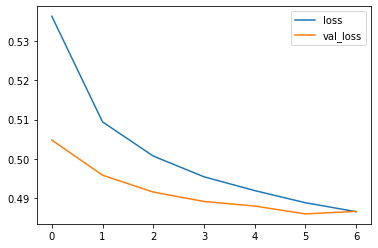

In [107]:
model_history[['loss','val_loss']].plot()

<AxesSubplot:>

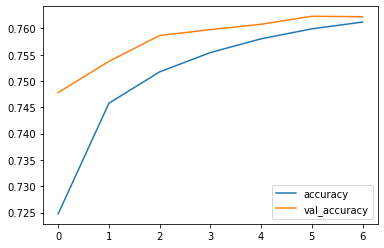

In [109]:
model_history[['accuracy','val_accuracy']].plot()

## <a name="p12">Predictions</a>

In [110]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"

In [111]:
scores = model.predict(x_test,verbose=1,batch_size=10000)

8/8 [==============================] - 19s 2s/step


In [112]:
y_pred_1d = [decode_sentiment(score) for score in scores]

## <a name="p13">Classification Report and Confusion Matrix</a>

In [123]:
def plot_confusion_matrix(cm,classes):
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,fontsize=13)
    plt.yticks(tick_marks,classes,fontsize=13)
    
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

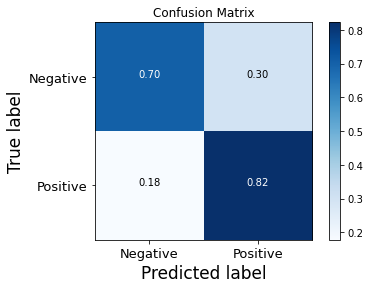

In [124]:
cm = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plot_confusion_matrix(cm,classes=test_data['sentiment'].unique())

In [125]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.80      0.70      0.75     39875
    Positive       0.74      0.82      0.78     40125

    accuracy                           0.76     80000
   macro avg       0.77      0.76      0.76     80000
weighted avg       0.77      0.76      0.76     80000

